### Try to using torchattack

In [99]:
import torchattacks # type: ignore
import argparse
import pathlib
import time
import matplotlib.pyplot as plt # type: ignore
import pandas as pd # type: ignore
import PIL.Image # type: ignore
import torch.nn.functional as F # type: ignore
import sys
sys.argv = ['run.py']

try:
    import apex
except ImportError:
    pass
import numpy as np # type: ignore
import torch# type: ignore
import torch.nn as nn # type: ignore
import torch.distributed as dist# type: ignore
import torchvision# type: ignore
import cv2# type: ignore

from fvcore.common.checkpoint import Checkpointer# type: ignore

from pytorch_image_classification import (
    apply_data_parallel_wrapper,
    create_dataloader,
    create_loss,
    create_model,
    create_optimizer,
    create_scheduler,
    get_default_config,
    update_config,
)
from pytorch_image_classification.config.config_node import ConfigNode
from pytorch_image_classification.utils import (
    AverageMeter,
    DummyWriter,
    compute_accuracy,
    count_op,
    create_logger,
    create_tensorboard_writer,
    find_config_diff,
    get_env_info,
    get_rank,
    save_config,
    set_seed,
    setup_cudnn,
)
from pytorch_image_classification import (
    get_default_config,
    create_model,
    create_transform,
)

global global_step
global_step = 0


def load_config():
    parser = argparse.ArgumentParser()
    parser.add_argument('--config', type=str,default = '/root/ZYM/zym/AI_S/torch_classification/configs/self_dataset/resnet_3.yaml' )
    parser.add_argument('--resume', type=str, default='')
    parser.add_argument('--local_rank', type=int, default=0)
    parser.add_argument('options', default=None, nargs=argparse.REMAINDER)
    args = parser.parse_args()

    config = get_default_config()
    if args.config is not None:
        config.merge_from_file(args.config)
    config.merge_from_list(args.options)
    if not torch.cuda.is_available():
        config.device = 'cpu'
        config.train.dataloader.pin_memory = False
    if args.resume != '':
        config_path = pathlib.Path(args.resume) / 'config.yaml'
        config.merge_from_file(config_path.as_posix())
        config.merge_from_list(['train.resume', True])
    config.merge_from_list(['train.dist.local_rank', args.local_rank])
    config = update_config(config)
    config.freeze()
    return config




config = load_config()

set_seed(config)
setup_cudnn(config)

epoch_seeds = np.random.randint(np.iinfo(np.int32).max // 2,
                                size=config.scheduler.epochs)

if config.train.distributed:
    dist.init_process_group(backend=config.train.dist.backend,
                            init_method=config.train.dist.init_method,
                            rank=config.train.dist.node_rank,
                            world_size=config.train.dist.world_size)
    torch.cuda.set_device(config.train.dist.local_rank)
    
model = create_model(config)
checkpoint = torch.load('/root/ZYM/zym/AI_S/torch_classification/experiments/mnist/resnet/exp05/checkpoint_00160.pth')
model.load_state_dict(checkpoint['model'],strict=False)
transform = create_transform(config, is_train=True)

device = torch.device("cpu")
model.to(device)
_ = model.eval()

#names = [index2label[index] for index in indices]
print("Finish!")

Finish!


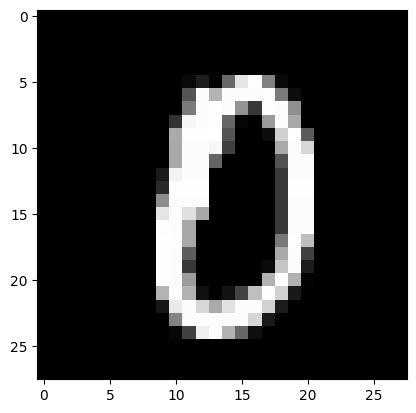

In [104]:
image = cv2.imread('./data/MNIST/test/0/5.png')
img  = image[:, :, ::-1]

data = transform(PIL.Image.fromarray(img))
with torch.no_grad():
    pred = model(data.unsqueeze(0).to(device))
prob = F.softmax(pred, dim=1).cpu()

scores, indices = prob.topk(k=3)
scores = scores.numpy().ravel()

indices = indices.numpy().ravel()
plt.imshow(image[:, :, ::-1])
plt.show()

In [101]:
pd.DataFrame({'label': indices, 'score': scores})

,label,score
0,0,0.999985
1,2,0.000011
2,1,0.000004


### 实现基于模型和参数的标签预测，现在实现攻击

/root/miniconda3/envs/zym38/lib/python3.8/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


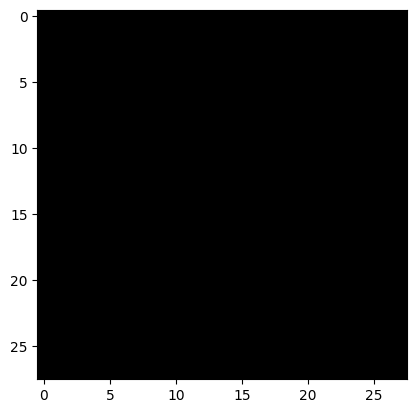

In [107]:
device = torch.device("cpu")
img_batch0 = np.expand_dims(image,axis=0)
img_batch = torch.from_numpy(np.transpose(img_batch0,(0,3,1,2))).float().to(device)
labels0 = np.array([0])  # 示例标签数据
labels = torch.tensor(labels0).long().to(device)
atk1 = torchattacks.CW(model=model.to(device),c=1,kappa=0,steps=50,lr=0.01)
x = atk1(img_batch.to(device),labels=labels.to(device))
adv_image_batch_cpu = x.cpu()*255
adv_img = (adv_image_batch_cpu.numpy())[0]
plt.imshow(np.transpose(adv_img,(1,2,0)))
plt.show()

In [106]:
def get_predict(img,model,transform,device,k):
    
    data = transform(PIL.Image.fromarray(img))
    with torch.no_grad():
        pred = model(data.unsqueeze(0).to(device))
    prob = F.softmax(pred, dim=1).cpu()

    scores, indices = prob.topk(k)
    scores = scores.numpy().ravel()
    indices = indices.numpy().ravel()
    return scores,indices
adv_image_uint8 = (adv_img * 255).astype(np.uint8)
adv_img_input = adv_image_uint8.transpose(1, 2, 0)
s,i = get_predict(adv_img_input,model,transform,device,3)
pd.DataFrame({'label': i, 'score': s})

/tmp/ipykernel_1690213/4091743404.py:12: RuntimeWarning: invalid value encountered in cast
  adv_image_uint8 = (adv_img * 255).astype(np.uint8)


,label,score
0,1,0.990209
1,2,0.008971
2,0,0.000819


## Test self-made CW attack

In [89]:
import torch # type: ignore
import PIL.Image # type: ignore 
device = torch.device('cuda')
import torch.nn.functional as F # type: ignore
import pandas as pd # type: ignore
def get_predict(img,model,device,k):
    img = torch.tensor(img.astype(np.float32)/255).to(device)
    img = img.permute(2,0,1) # convert HWC to CHW
    if len(img.shape) == 3:  # 单个图像
        img = img.unsqueeze(0)  # 增加 batch 维度 
    _ = model.eval()
    with torch.no_grad():
        result = model(img).squeeze(0)
        prob = F.softmax(result, dim=0).cpu()
    scores, indices = prob.topk(k)
    #print(scores,'\n',indices)
    return indices,prob

In [91]:
from tools.import_model import trmodel
from attack.CW import CWAttack
import numpy as np # type: ignore
import cv2# type: ignore

cfg_path = './configs/self_dataset/resnet_3.yaml'
pth_path = './experiments/mnist/resnet/exp05/checkpoint_00160.pth'

#model = trmodel(cfg_path,pth_path).get_model()
img_raw = cv2.imread('./data/MNIST/test/1/26.png')
_ = model.eval()
i,p = get_predict(img_raw/255,model,device,k=3)
i,p

(tensor([0, 2, 1]), tensor([9.8407e-01, 1.6612e-14, 1.5930e-02]))

In [92]:
img = np.copy(img_raw)
image = np.transpose(img,(2,0,1))
cw = CWAttack(model, img, c=3, lr=0.1, target=1,max_iteration=80)
adv_img = cw.attack()
adv_img_np = (adv_img.cpu().detach()).numpy()
adv_uint = (adv_img_np*255).astype(np.uint8)
#cv2.imwrite("./cw_adv.jpg",adv_uint)


/root/ZYM/zym/AI_S/torch_classification/attack/CW.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  w = torch.tensor(torch.atanh(2*self.x-1),requires_grad=True).to(device)
100%|██████████| 80/80 [00:03<00:00, 22.72it/s]


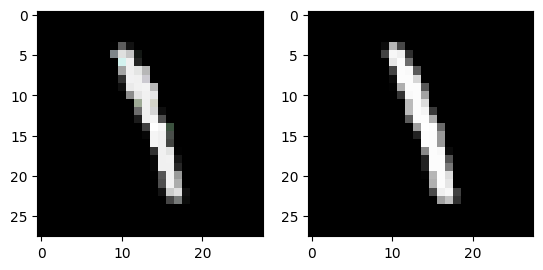

In [93]:
import matplotlib.pyplot as plt # type: ignore
plt.figure()
plt.subplot(1,2,1)
plt.imshow(adv_uint)
plt.subplot(1,2,2)
plt.imshow(img_raw)
plt.show()

In [ ]:
i,s = get_predict(adv_uint,model,device,3)
i_raw,s_raw = get_predict(img_raw,model,device,3)
df1 = pd.DataFrame({'label': i, 'score': s,})
df2 = pd.DataFrame({'Raw_label': i_raw, 'score': s_raw})
df11 = df1.sort_values(by='score', ascending=False)
df22 = df2.sort_values(by='score', ascending=False)
display(df11)
display(df22) #最左侧的为pandas自带的index序列，第二列为模型预测标签

,label,score
0,0,0.596084
2,1,0.403525
1,2,0.000391


,Raw_label,score
2,1,0.967273
0,2,0.032626
1,0,0.000101
